In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading Strategy

For this exploratory analysis, I'm using only the **training set** to ensure:
- No data leakage from validation/test sets
- Realistic feature correlations that reflect true predictive power
- Consistency with production pipeline approach

**Dataset:** `data/processed/train.csv` (60% of cleaned data, ~2.7M flights)

In [86]:
df = pd.read_csv("../data/processed/train.csv", low_memory=False)
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,7,30,4,OO,ELP,DEN,1247,113.0,563,1440,0.0
1,7,4,6,DL,ATL,LIT,1050,94.0,453,1124,27.0
2,5,16,6,EV,EWR,MHT,1440,80.0,209,1600,70.0
3,2,25,3,OO,LAX,SMF,735,84.0,373,859,3.0
4,5,14,4,DL,FLL,DTW,1128,182.0,1127,1430,-16.0


In [68]:
df['ORIGIN_AIRPORT'].unique()

array(['ELP', 'ATL', 'EWR', 'LAX', 'FLL', 'SFO', '13303', '12889',
       '11278', 'MKE', 'IAD', 'DEN', 'STL', 'LGA', 'IAH', 'PHF', 'CHS',
       'DTW', 'ANC', 'GRR', 'MSP', 'CLT', 'CMH', 'PHX', 'BNA', 'JFK',
       'ORD', 'HOU', 'PBI', 'SEA', 'GRK', '10721', 'DCA', 'BOS', 'GCC',
       'CLE', 'DFW', 'EUG', 'ICT', '12323', 'RDU', '10800', 'TPA', 'SLC',
       'CHO', '13487', 'MDW', 'IAG', 'EVV', 'MCO', 'ADQ', 'SDF', 'SJC',
       '10397', 'BDL', '10821', '14869', 'LAS', 'BWI', '13891', '12953',
       'PHL', 'OAK', 'DAL', 'MHT', 'MHK', 'DRO', 'SAN', '13930', 'SYR',
       'SAT', 'OMA', 'JAN', '12884', 'MSY', 'GEG', 'BJI', 'MSN', 'PSC',
       'BZN', '13198', 'PIT', 'MEM', 'TUL', 'RNO', 'IND', 'AVL', 'MCI',
       'AUS', 'FCA', 'ACV', '11298', '11775', 'LBB', 'OGG', 'PDX', 'RIC',
       'BUF', 'LNK', 'CVG', 'CSG', '11042', 'JAX', 'MOB', '11292', 'OKC',
       'SJU', 'SNA', 'ABE', '11618', '14107', 'TRI', 'RSW', 'SMF',
       '14908', 'ORF', 'ONT', '12266', '11433', 'ALB', '14771', '1323

In [69]:
df['ORIGIN_AIRPORT'].unique().shape

(628,)

## Create Airport Features

**Challenge:** 628 unique airports - too many for one-hot encoding.

**Solution:**
1. Target encoding: Average delay per airport (from train only)
2. One-hot: Top 10 busiest airports
3. Airport type: Major vs Regional
4. Traffic volume: Flight count per airport

**Data leakage prevention:** All stats calculated from training data only!

In [70]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,7,30,4,OO,ELP,DEN,1247,113.0,563,1440,0.0
1,7,4,6,DL,ATL,LIT,1050,94.0,453,1124,27.0
2,5,16,6,EV,EWR,MHT,1440,80.0,209,1600,70.0
3,2,25,3,OO,LAX,SMF,735,84.0,373,859,3.0
4,5,14,4,DL,FLL,DTW,1128,182.0,1127,1430,-16.0


In [90]:
def classify_airport(code):
    if code.isalpha() and len(code) == 3:
        return 'MAJOR'
    else:
        return 'REGIONAL'
    
df['ORIGIN_A_TYPE'] = df['ORIGIN_AIRPORT'].apply(classify_airport)
df['DESTINATION_A_TYPE'] = df['DESTINATION_AIRPORT'].apply(classify_airport)

airport_type_traffic_volume = df['DESTINATION_A_TYPE'].value_counts()
airport_type_avg_delay = df.groupby('DESTINATION_A_TYPE')['ARRIVAL_DELAY'].mean()
print(f"Traffic volume by airport type {airport_type_traffic_volume}")
print(f"Average delay by airport type {airport_type_avg_delay}")

Traffic volume by airport type DESTINATION_A_TYPE
MAJOR       3138608
REGIONAL     289796
Name: count, dtype: int64
Average delay by airport type DESTINATION_A_TYPE
MAJOR       4.885059
REGIONAL   -0.849387
Name: ARRIVAL_DELAY, dtype: float64


In [91]:
df['IS_MAJOR_ORIGIN'] = (df['ORIGIN_A_TYPE'] == 'MAJOR').astype(int)
df['IS_MAJOR_DESTINATION'] = (df['DESTINATION_A_TYPE'] == 'MAJOR').astype(int)
df = df.drop(['ORIGIN_A_TYPE', 'DESTINATION_A_TYPE'], axis=1)

In [92]:
# Avergae delay per airport
origin_avg_delay = df.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].mean().round(2)
destination_avg_delay = df.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].mean().round(2)
df['ORIGIN_AVG_DELAY'] = df['ORIGIN_AIRPORT'].map(origin_avg_delay)
df['DESTINATION_AVG_DELAY'] = df['DESTINATION_AIRPORT'].map(destination_avg_delay)

In [93]:
# One hot encoding top 10 airports
origin_traffic_volume = df['ORIGIN_AIRPORT'].value_counts()
destination_traffic_volume = df['DESTINATION_AIRPORT'].value_counts()

for airport in origin_traffic_volume.head(10).index.tolist():
    df[f"OA_{airport}"] = (df['ORIGIN_AIRPORT'] == airport).astype(int)
for airport in destination_traffic_volume.head(10).index.tolist():
    df[f"DA_{airport}"] = (df['DESTINATION_AIRPORT'] == airport).astype(int)

In [94]:
origin_traffic_volume = df['ORIGIN_AIRPORT'].value_counts()
destination_traffic_volume = df['DESTINATION_AIRPORT'].value_counts()
df['ORIGIN_TRAFFIC'] = df['ORIGIN_AIRPORT'].map(origin_traffic_volume)
df['DESTINATION_TRAFFIC'] = df['DESTINATION_AIRPORT'].map(destination_traffic_volume)

In [89]:
airline_count = df['AIRLINE'].value_counts()
for airline in airline_count.index.tolist():
    df[f'AIRLINE_{airline}'] = (df['AIRLINE'] == airline).astype(int)

In [95]:
df = df.drop(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1)
df.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIRLINE_WN,AIRLINE_DL,...,DA_DFW,DA_DEN,DA_LAX,DA_SFO,DA_PHX,DA_IAH,DA_LAS,DA_MSP,ORIGIN_TRAFFIC,DESTINATION_TRAFFIC
0,7,30,4,1247,113.0,563,1440,0.0,0,0,...,0,1,0,0,0,0,0,0,7139,116018
1,7,4,6,1050,94.0,453,1124,27.0,0,1,...,0,0,0,0,0,0,0,0,206273,6072
2,5,16,6,1440,80.0,209,1600,70.0,0,0,...,0,0,0,0,0,0,0,0,59080,3752
3,2,25,3,735,84.0,373,859,3.0,0,0,...,0,0,0,0,0,0,0,0,115242,21996
4,5,14,4,1128,182.0,1127,1430,-16.0,0,1,...,0,0,0,0,0,0,0,0,43518,64069


In [96]:
corr_matrix = df.corr()
corr_matrix['ARRIVAL_DELAY'].sort_values(ascending=False)

ARRIVAL_DELAY            1.000000
SCHEDULED_DEPARTURE      0.100273
SCHEDULED_ARRIVAL        0.089195
ORIGIN_AVG_DELAY         0.073458
DESTINATION_AVG_DELAY    0.067170
IS_MAJOR_ORIGIN          0.040608
IS_MAJOR_DESTINATION     0.040608
AIRLINE_NK               0.036120
AIRLINE_F9               0.025931
OA_ORD                   0.024218
ORIGIN_TRAFFIC           0.023528
AIRLINE_EV               0.018551
DA_ORD                   0.016369
OA_DEN                   0.013336
OA_DFW                   0.012885
AIRLINE_B6               0.012710
AIRLINE_MQ               0.012453
AIRLINE_OO               0.012378
OA_IAH                   0.011821
DA_LAX                   0.008324
DA_SFO                   0.008234
AIRLINE_UA               0.007589
DA_DFW                   0.006994
DESTINATION_TRAFFIC      0.006958
OA_LAX                   0.006628
OA_LAS                   0.006280
OA_SFO                   0.005624
DA_IAH                   0.004970
DA_DEN                   0.003550
AIRLINE_VX    

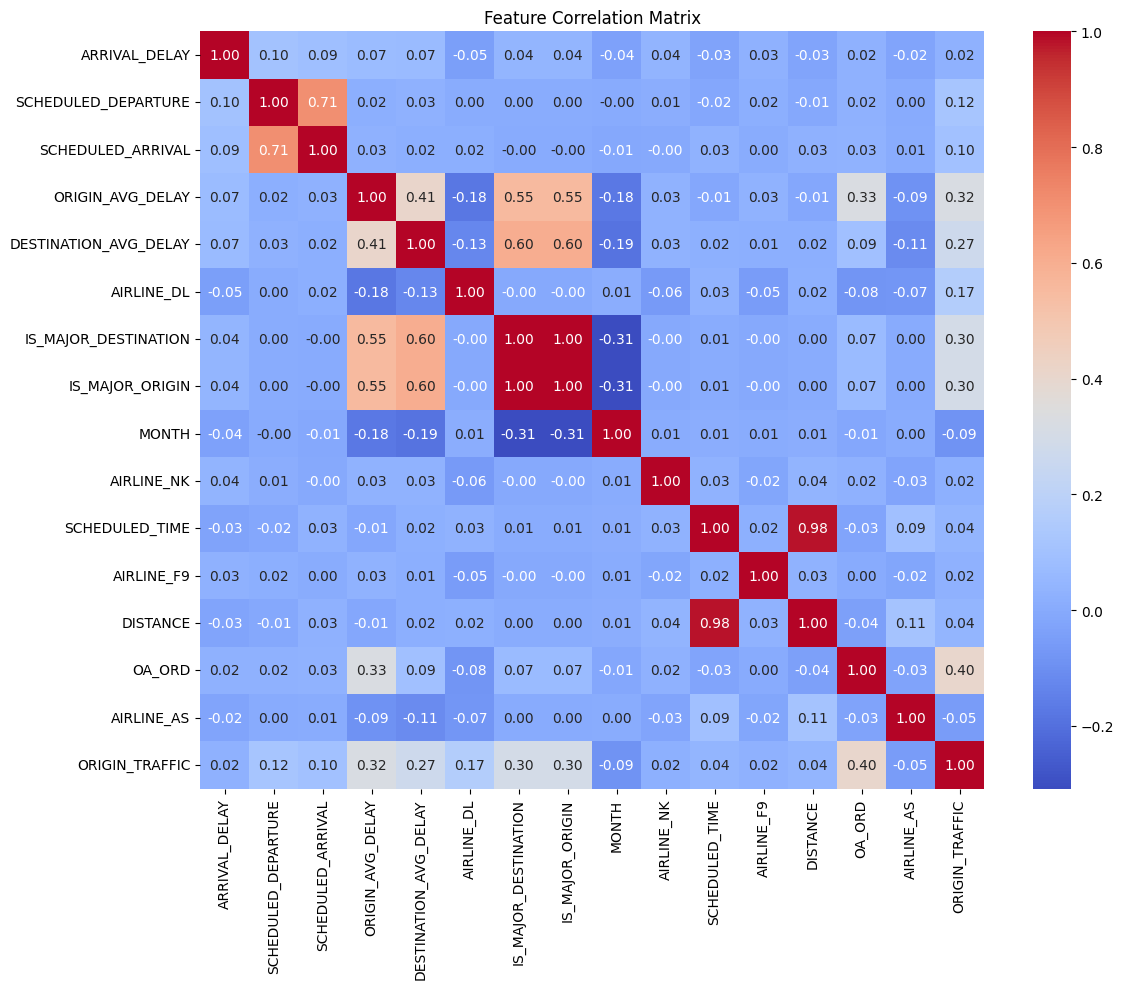

In [97]:
top_features = corr_matrix['ARRIVAL_DELAY'].abs().sort_values(ascending=False).head(16).index
plt.figure(figsize=(12,10))

corr_subset = df[top_features].corr()
sns.heatmap(corr_subset, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

## Multicollinearity Removal

Removed two features due to high multicollinearity:

1. **`IS_MAJOR_ORIGIN`**: Perfect correlation (1.00) with `IS_MAJOR_DESTINATION`
   - Both features are identical (major airports fly to major airports)
   - Kept `IS_MAJOR_DESTINATION` only

2. **`DISTANCE`**: Very high correlation (0.98) with `SCHEDULED_TIME`
   - Distance largely determines scheduled flight duration
   - Kept `SCHEDULED_TIME` as it captures airline-specific planning (buffers, routing)

In [101]:
df = df.drop(['IS_MAJOR_ORIGIN', 'DISTANCE'], axis=1)